## Dataset used :
- https://www.kaggle.com/datasets/asaniczka/video-game-sales-2024

## References
- https://www.kaggle.com/code/jruots/forecasting-video-game-sales
- 

In [224]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns


In [225]:
# Load the dataset
data = pd.read_csv("vgchartz-2024.csv")

# Check for missing values
print(data.isnull().sum())

img                 0
title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
last_update     46137
dtype: int64


In [226]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

,Missing Ratio
critic_score,89.568233
jp_sales,89.493252
na_sales,80.259623
pal_sales,79.967508
other_sales,76.368408
last_update,72.071045
total_sales,70.441765
release_date,11.014434
developer,0.026556


/tmp/ipykernel_31903/48055025.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


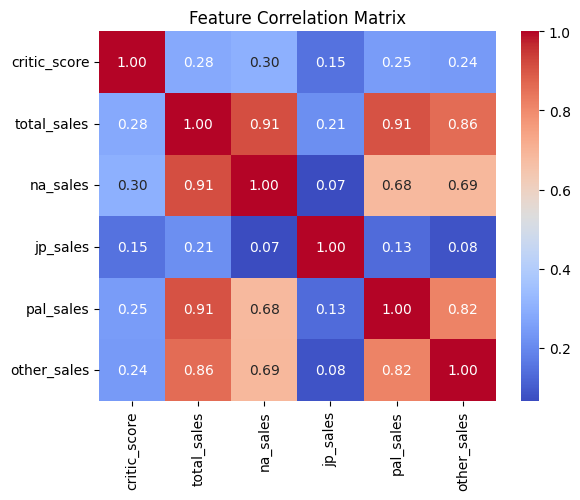

In [227]:
# Correlation heatmap
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


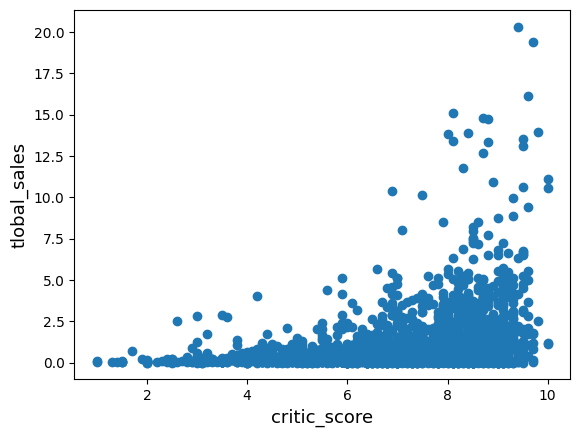

In [228]:
fig, ax = plt.subplots()
ax.scatter(x = data['critic_score'], y = data['total_sales'])
plt.ylabel('tlobal_sales', fontsize=13)
plt.xlabel('critic_score', fontsize=13)
plt.show()

In [229]:
# data = data.drop(data[(data['critic_score']<8) & (data['total_sales']>9)].index)
# data = data.drop(data[(data['critic_score']>8) & (data['total_sales']>15)].index)

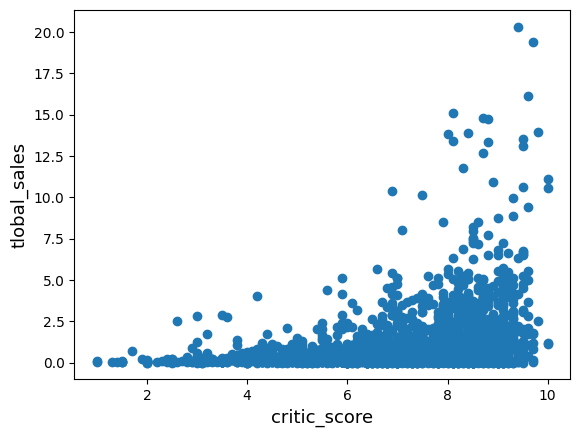

In [230]:
fig, ax = plt.subplots()
ax.scatter(x = data['critic_score'], y = data['total_sales'])
plt.ylabel('tlobal_sales', fontsize=13)
plt.xlabel('critic_score', fontsize=13)
plt.show()

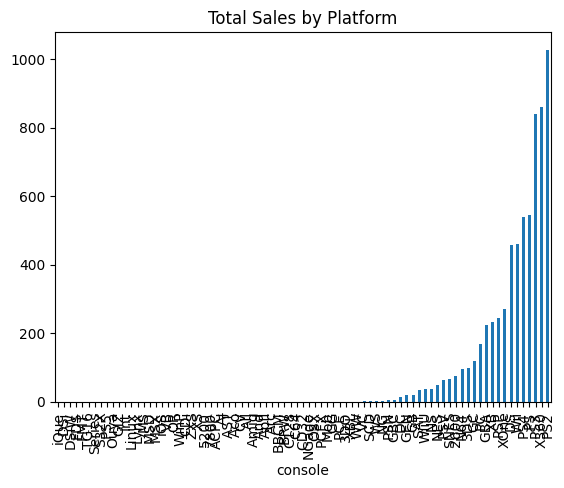

In [231]:
data.groupby('console')['total_sales'].sum().sort_values().plot(kind='bar')
plt.title('Total Sales by Platform')
plt.show()


In [232]:
#adjust output format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
print(pd.value_counts(data["console"]))

PC        12617
PS2        3565
DS         3288
PS4        2878
PS         2707
NS         2337
XBL        2120
PSN        2004
XOne       1963
PS3        1905
PSP        1807
X360       1735
Wii        1676
GBA        1659
GB         1599
SNES       1211
3DS        1192
All        1138
NES        1106
PSV        1105
And        1051
XB          982
GEN         804
DSiW        753
SAT         739
OSX         673
GC          663
VC          661
DC          655
PS5         648
XS          620
WiiU        554
2600        501
WW          465
Series      464
PCE         459
N64         393
Linux       370
MS          336
GG          332
3DO         305
SCD         218
WS          199
NG          172
iOS         155
Int         134
Lynx         89
DSi          76
5200         73
AJ           72
WinP         70
PCFX         67
BRW          63
NGage        61
7800         59
GIZ          55
Arc          52
CV           46
C64          34
OR           31
Amig         30
MSD          27
Ouya    

In [233]:
print(data.shape)

(64016, 14)


In [234]:
print(data.head)

<bound method NDFrame.head of                                                  img                             title console         genre             publisher  \
0      /games/boxart/full_6510540AmericaFrontccc.jpg                Grand Theft Auto V     PS3        Action        Rockstar Games   
1      /games/boxart/full_5563178AmericaFrontccc.jpg                Grand Theft Auto V     PS4        Action        Rockstar Games   
2                        /games/boxart/827563ccc.jpg       Grand Theft Auto: Vice City     PS2        Action        Rockstar Games   
3      /games/boxart/full_9218923AmericaFrontccc.jpg                Grand Theft Auto V    X360        Action        Rockstar Games   
4      /games/boxart/full_4990510AmericaFrontccc.jpg         Call of Duty: Black Ops 3     PS4       Shooter            Activision   
...                                              ...                               ...     ...           ...                   ...   
64011  /games/boxart/full_277983

## Preprocessing data

In [235]:
#since total_sales is our target, we have to get rid of all rows with missing values for total_sales
data = data.dropna(subset=["total_sales"])


In [236]:
top_consoles = data['console'].value_counts().head(8).index
data['console_grouped'] = data['console'].apply(lambda x: x if x in top_consoles else 'Other')
#data = pd.get_dummies(data, columns=['console_grouped'], drop_first=True)


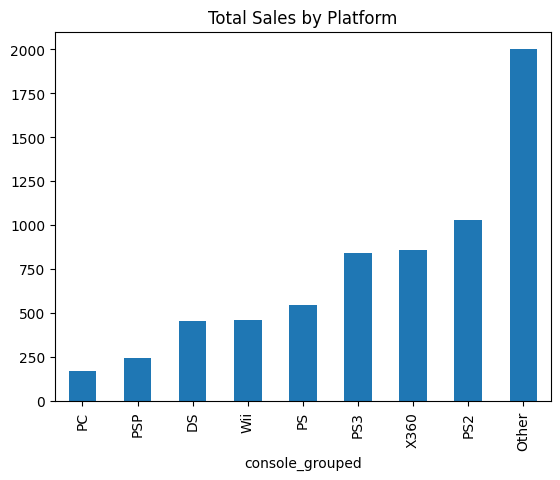

In [237]:
data.groupby('console_grouped')['total_sales'].sum().sort_values().plot(kind='bar')
plt.title('Total Sales by Platform')
plt.show()


In [238]:
data = pd.get_dummies(data, columns=['console_grouped'], drop_first=True)


In [239]:

#fill in missing critic score values with the mean of critic scores for each genre
data["critic_score"]  = data.groupby("genre")['critic_score'].transform(

    lambda x: x.fillna(x.mean())
)


In [240]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

,Missing Ratio
last_update,78.760173
jp_sales,64.454075
na_sales,33.215305
pal_sales,32.227037
other_sales,20.050735
release_date,0.475637
developer,0.021139


In [241]:
#One-hot encode categorical features and log-transform sales 
data['Log_Total_Sales'] = np.log1p(data['total_sales'])

In [242]:
#Group publishers into "Top 10" and "Other" since there is too many unique publishers
top_publishers = data['publisher'].value_counts().head(8).index
data['publisher_grouped'] = data['publisher'].apply(

    lambda x: x if x in top_publishers else 'Other'

)

In [243]:
#convert the release date to date_time and extract the month and date from it and put it into separate columns
def parse_date(date):
    try:
        return pd.to_datetime(date, format="%d%b%y")
    except ValueError:
        return pd.to_datetime(date, format="%Y-%m-%d")

data["release_date"] = data["release_date"].apply(parse_date)
data["month"] = data["release_date"].dt.month
data["year"] = data["release_date"].dt.year

# Drop irrelevant columns
columns_to_drop = ['img', 'console', 'last_update', 'release_date', 'developer', 'publisher', 'jp_sales', 'na_sales', 'pal_sales', 'other_sales']

data = data.drop(columns=columns_to_drop)

In [244]:
# Scale numerical features
from sklearn.preprocessing import RobustScaler, StandardScaler
scaler = RobustScaler()
data[["critic_score", "year"]] = scaler.fit_transform(data[["critic_score", "year"]])

encoded_data = pd.get_dummies(data, columns=['genre', 'publisher_grouped'], drop_first=True)

encoded_data['critic_score_year'] = data['critic_score'] * data['year']


In [245]:
data_na = (encoded_data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

,Missing Ratio
month,0.475637
year,0.475637
critic_score_year,0.475637


In [246]:
encoded_data = encoded_data.dropna(subset = ["critic_score_year"])
#encoded_data = encoded_data.drop(columns=["critic_score"])

X = encoded_data.drop(columns=['Log_Total_Sales','total_sales', 'title'])

y = encoded_data['Log_Total_Sales']

# Handle missing Year and Month values
X['year'] = X['year'].fillna(X['year'].median())

X['month'] = X['month'].fillna(X['month'].mode()[0])

#split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [247]:

models = {

    "Linear Regression": LinearRegression(),

    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),

    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

}

#linear model fit and training
models["Linear Regression"].fit(X_train,y_train)
y_pred = models["Linear Regression"].predict(X_test)

# Evaluate the model
mae_log = mean_absolute_error(y_test, y_pred)
rmse_log = mean_squared_error(y_test, y_pred, squared=False)
r2_log = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, np.expm1(y_pred))
rmse = mean_squared_error(y_test, np.expm1(y_pred), squared=False)
r2 = r2_score(y_test, np.expm1(y_pred))

# Print evaluation metrics
print("Linear Regression Performance:")
print(f"Log MAE: {mae_log}")
print(f"Log RMSE: {rmse_log}")

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Linear Regression Performance:
Log MAE: 0.18288427713848554
Log RMSE: 0.2745849908255897
MAE: 0.1981120532873341
RMSE: 0.27806714316008707
R²: 0.21151129865434481


In [248]:

#this module for hyperparameter tuning on the Random Forest and Gradient boost models

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Hyperparameter grids
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 1.0]
    }
}

# Results dictionary to store the best models and their performance
tuned_models = {}
results = []

for name, params in param_grids.items():
    if name == "Random Forest":
        model = RandomForestRegressor(random_state=42)
    elif name == "XGBoost":
        model = XGBRegressor(random_state=42)
    
    # Use RandomizedSearchCV for faster tuning
    search = RandomizedSearchCV(
        model,
        param_distributions=params,
        n_iter=20,  # Number of random combinations to try
        scoring="neg_root_mean_squared_error",  # Use MAE for scoring
        cv=3,  # 3-fold cross-validation
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    
    # Fit the search
    search.fit(X_train, y_train)
    
    # Store the best model and its performance
    tuned_models[name] = search.best_estimator_
    best_params = search.best_params_
    best_score = -search.best_score_  # Convert negative MAE to positive
    
    results.append({"Model": name, "Best RMSE": best_score, "Best Params": best_params})

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)



# Convert results to a DataFrame for display

results_df = pd.DataFrame(results)

print(results_df)


/home/tonyzalez/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/tonyzalez/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain f

           Model  Best RMSE                                        Best Params
0  Random Forest   0.247033  {'n_estimators': 200, 'min_samples_split': 10,...
1        XGBoost   0.244028  {'subsample': 0.8, 'n_estimators': 100, 'max_d...


In [249]:
tuned_models["Linear Regression"] = models["Linear Regression"]

In [250]:
# Evaluate tuned models
final_results = []

for name, model in tuned_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_original = np.expm1(y_pred)
    y_test_original = np.expm1(y_test)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    rmse = mean_squared_error(y_test_original, y_pred_original, squared=False)
    r2 = r2_score(y_test_original, y_pred_original)
    final_results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2})

# Display final results
final_results_df = pd.DataFrame(final_results)
print(final_results_df)

               Model       MAE      RMSE        R²
0      Random Forest  0.263123  0.673075  0.331253
1            XGBoost  0.258295  0.675766  0.325894
2  Linear Regression  0.298478  0.767985  0.129354


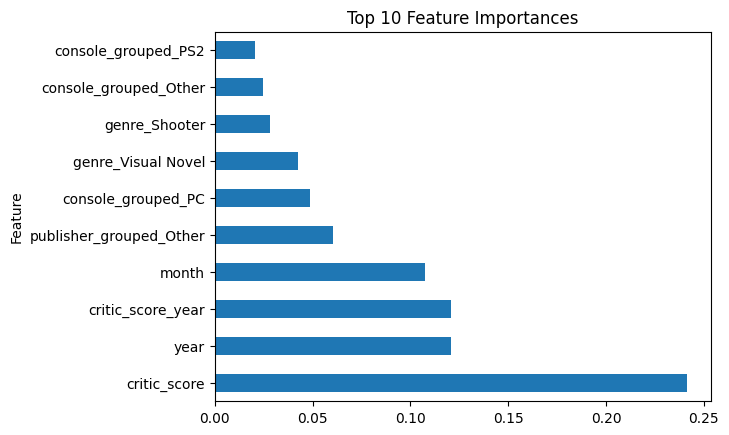

In [251]:
# Feature importance from Random Forest
import matplotlib.pyplot as plt
import pandas as pd

importance = tuned_models["Random Forest"].feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values(by='Importance', ascending=False)

# Plot
importance_df.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title('Top 10 Feature Importances')
plt.show()

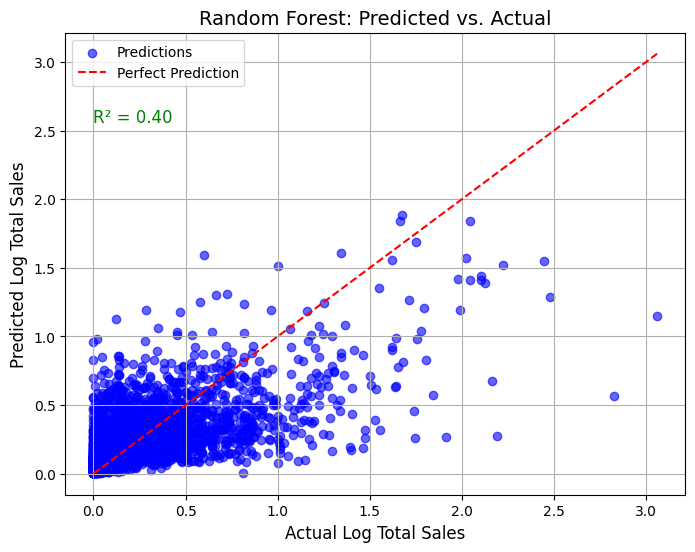

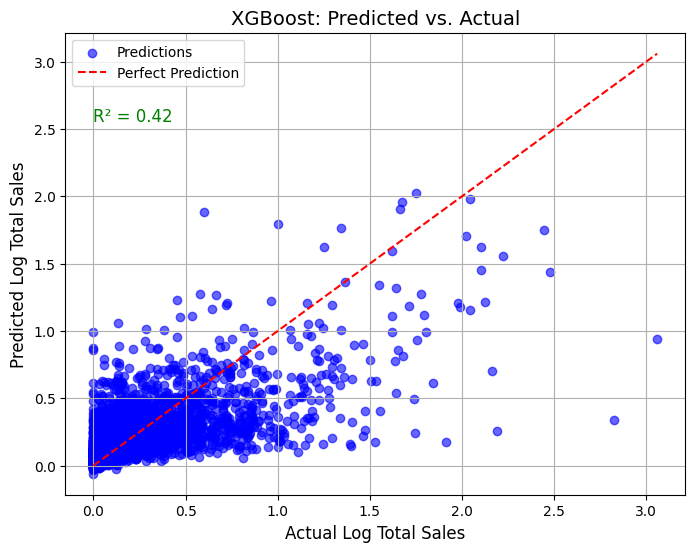

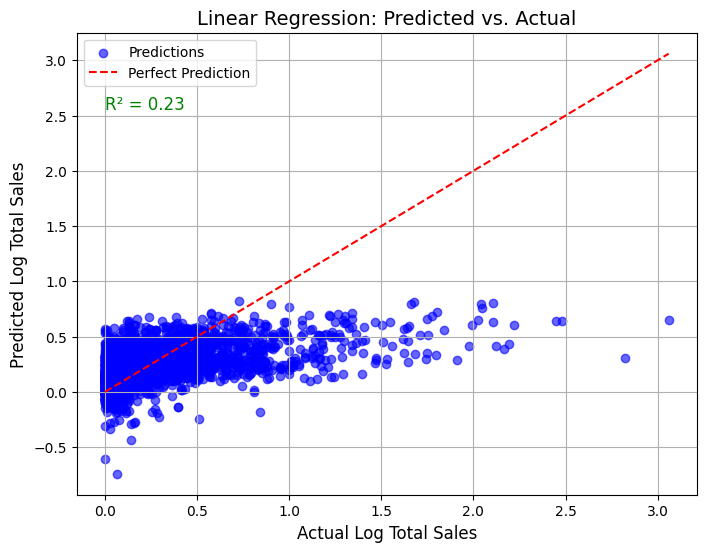

In [252]:
#scatterplot for the models

import matplotlib.pyplot as plt
import numpy as np

# Refined Scatter Plot
for name, model in tuned_models.items():
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label="Predictions", color="blue")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="Perfect Prediction")
    plt.title(f"{name}: Predicted vs. Actual", fontsize=14)
    plt.xlabel("Actual Log Total Sales", fontsize=12)
    plt.ylabel("Predicted Log Total Sales", fontsize=12)
    plt.legend()
    plt.grid()
    
    # Add R² score as annotation
    r2 = r2_score(y_test, y_pred)
    plt.text(y_test.min(), y_test.max() - 0.5, f"R² = {r2:.2f}", fontsize=12, color="green")
    
    plt.show()


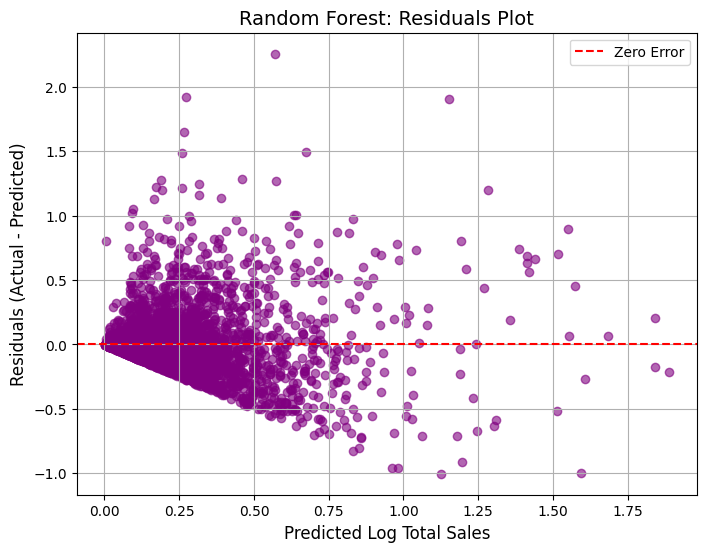

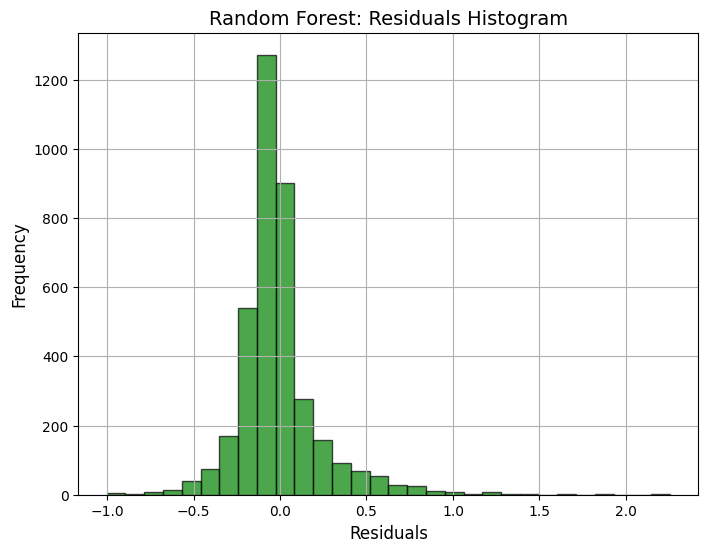

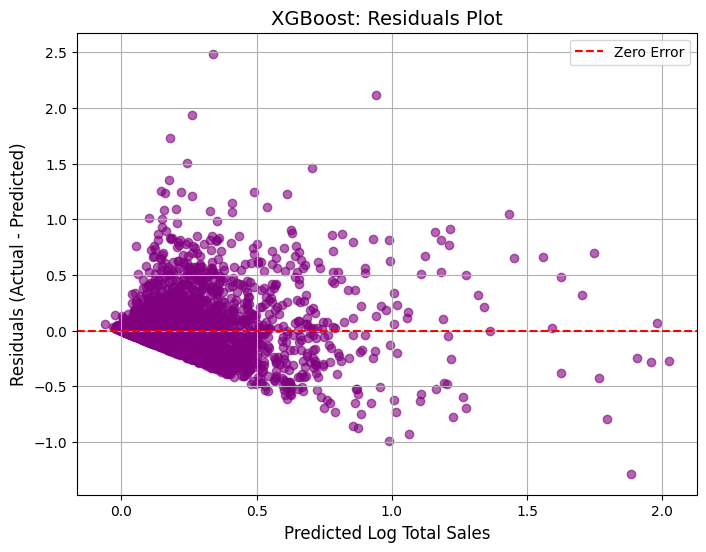

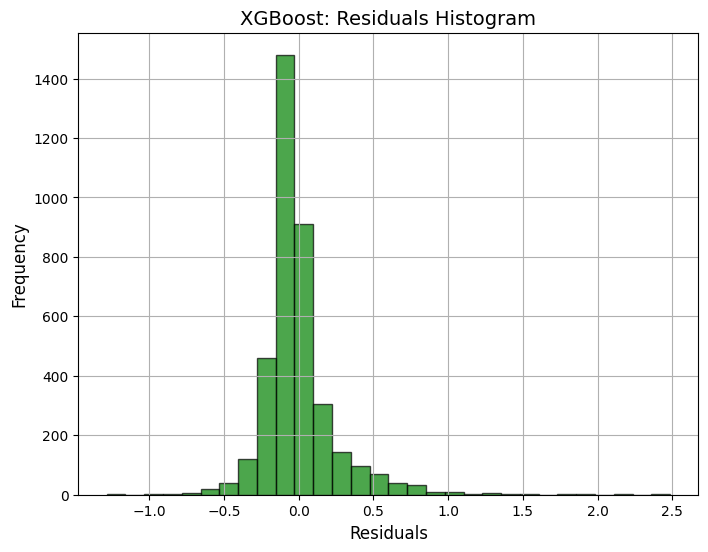

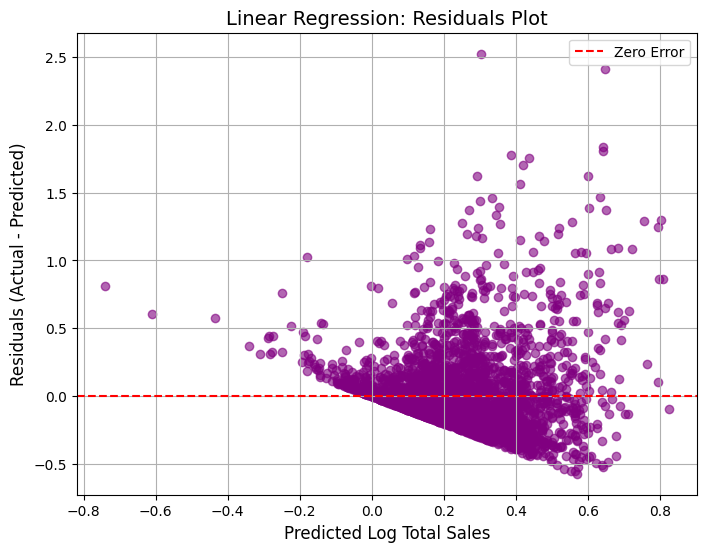

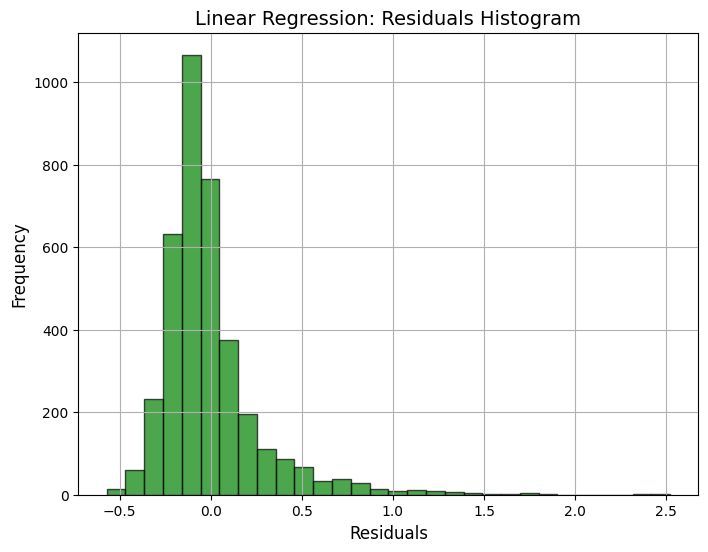

In [253]:
# Residual Plot for models
for name, model in tuned_models.items():
    # Get predictions
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    
    # Scatter residual plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, color="purple")
    plt.axhline(0, color="red", linestyle="--", label="Zero Error")
    plt.title(f"{name}: Residuals Plot", fontsize=14)
    plt.xlabel("Predicted Log Total Sales", fontsize=12)
    plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()
    
    # Histogram of residuals
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, color="green", alpha=0.7, edgecolor="black")
    plt.title(f"{name}: Residuals Histogram", fontsize=14)
    plt.xlabel("Residuals", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid()
    plt.show()


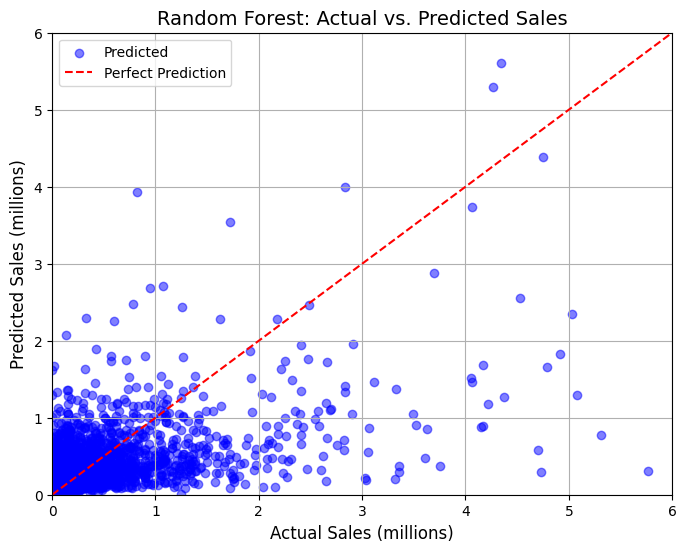

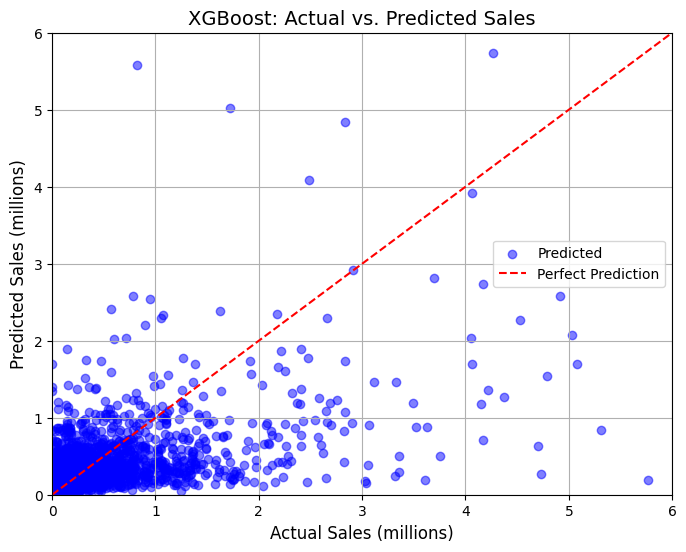

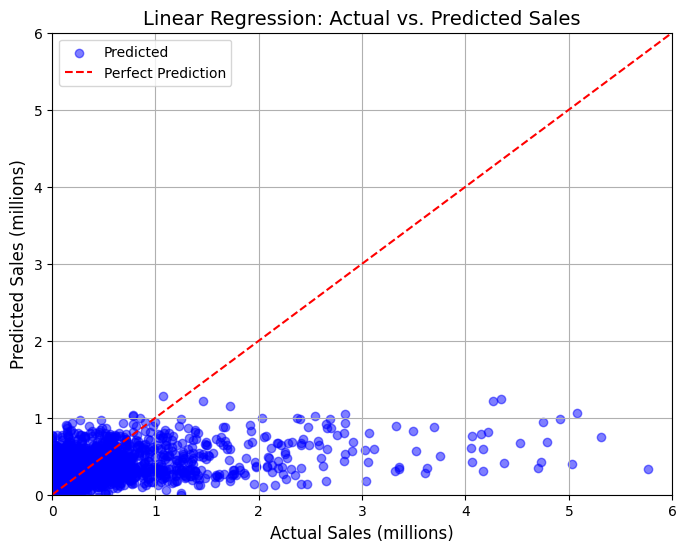

In [254]:
import matplotlib.pyplot as plt

# Visualize Actual vs. Predicted Sales
for name, model in tuned_models.items():
    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_original = np.expm1(y_pred)  # Convert back from log scale
    y_test_original = np.expm1(y_test)
    
    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_original, y_pred_original, alpha=0.5, label="Predicted", color="blue")
    plt.plot(
        [y_test_original.min(), y_test_original.max()],
        [y_test_original.min(), y_test_original.max()],
        color="red", linestyle="--", label="Perfect Prediction"
    )
    plt.title(f"{name}: Actual vs. Predicted Sales", fontsize=14)
    plt.xlabel("Actual Sales (millions)", fontsize=12)
    plt.ylabel("Predicted Sales (millions)", fontsize=12)
    plt.legend()
    plt.grid()
      # Adjust the x and y axis range
    plt.xlim(0, 6)  # Set the x-axis range (e.g., 0 to 10 million sales)
    plt.ylim(0, 6)  # Set the y-axis range (e.g., 0 to 10 million sales)
    
    plt.show()


In [255]:

#save the model
import joblib

# Save the model
joblib.dump(tuned_models["Linear Regression"], "linear_model.joblib")

# Load the model
loaded_model = joblib.load("linear_model.joblib")

# Use the loaded model for predictions
y_pred_loaded = loaded_model.predict(X_test)

print(y_pred_loaded)

[0.07864849 0.18306867 0.52139899 ... 0.17620071 0.21584976 0.26831565]


## Using the Models

In [261]:
# Example input features for a new game (non-encoded)
new_game = {
    "critic_score": 85,  # Numerical
    "year": 2023,        # Numerical
    "month": 11,         # Numerical
    "console": "PS4",    # Categorical
    "genre": "Action",   # Categorical
    "publisher": "Sony"  # Categorical
}

# Convert input to DataFrame
new_game_df = pd.DataFrame([new_game])

# Encode categorical features dynamically
# Match the training encoding logic

# One-hot encode 'console'
console_categories = [col for col in X_train.columns if col.startswith("console_")]
for category in console_categories:
    new_game_df[category] = (new_game_df["console"] == category.split("_")[1]).astype(int)

# One-hot encode 'genre'
genre_categories = [col for col in X_train.columns if col.startswith("genre_")]
for category in genre_categories:
    new_game_df[category] = (new_game_df["genre"] == category.split("_")[1]).astype(int)

# Target encode 'publisher' (replace this with the target-encoding logic used during training)
# publisher_means = data.groupby("publisher")["total_sales"].mean()
# new_game_df["publisher_encoded"] = new_game_df["publisher"].map(publisher_means).fillna(data["total_sales"].mean())

# Drop unused original categorical columns
new_game_df = new_game_df.drop(columns=["console", "genre", "publisher"])

# Reorder columns to match training data
for col in X_train.columns:
    if col not in new_game_df:
        new_game_df[col] = 0  # Add missing columns with default values

new_game_df = new_game_df[X_train.columns]

# Predict with the model
best_model = tuned_models["Random Forest"]  # Replace with the desired model
predicted_log_sales = best_model.predict(new_game_df)

# Convert from log scale to original scale
predicted_sales = np.expm1(predicted_log_sales)

print(f"Predicted Total Sales: {predicted_sales[0]:.2f} million copies")


Predicted Total Sales: 3.85 million copies


In [260]:
joblib.dump(tuned_models["Random Forest"], "forest_model.joblib")

loaded_model = joblib.load("forest_model.joblib")

predicted_log_sales = loaded_model.predict(new_game)

# Convert the log-transformed prediction back to the original scale
predicted_sales = np.expm1(predicted_log_sales)

print(f"Predicted Total Sales: {predicted_sales[0]:.2f} million units")

/home/tonyzalez/.local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


TypeError: float() argument must be a string or a number, not 'dict'

In [ ]:
joblib.dump(tuned_models["XGBoost"], "xg_model.joblib")

loaded_model = joblib.load("xg_model.joblib")

predicted_log_sales = loaded_model.predict(new_game)

# Convert the log-transformed prediction back to the original scale
predicted_sales = np.expm1(predicted_log_sales)

print(f"Predicted Total Sales: {predicted_sales[0]:.2f} million units")

Predicted Total Sales: 3.63 million units


## Everything below is not necessary. It was my initial approach and is not being used. Still included for reference though. 

In [ ]:
data = data[(data['console'] == 'PC') | (data['console'] == 'PS4') 
            | (data['console'] == 'NS') 
            | (data['console'] == 'XBL')| (data['console'] == 'PSN')
            | (data['console'] == 'XOne')| (data['console'] == 'PS3')
            | (data['console'] == 'X360')
            | (data['console'] == 'Wii')]

print(pd.value_counts(data["console"]))

KeyError: 'console'

In [ ]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

In [ ]:

# Drop rows with missing target values
data = data.dropna(subset=["total_sales","critic_score", "release_date", "developer"])
print(data.shape)

data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)


In [ ]:

data = data[["console", "genre", "release_date", "publisher", "developer", "total_sales", "critic_score"]]

data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

In [ ]:
top_publishers = data["publisher"].value_counts().head(10).index
top_developers = data["developer"].value_counts().head(10).index


data["publisher"] = data["publisher"].apply(lambda x: x if x in top_publishers else "other_publishers")
data["developer"] = data["developer"].apply(lambda x: x if x in top_developers else "other_developers")



In [ ]:

# Drop rows with missing categorical data
data = data.dropna()

def parse_date(date):
    try:
        return pd.to_datetime(date, format="%d%b%y")
    except ValueError:
        return pd.to_datetime(date, format="%Y-%m-%d")

data["release_date"] = data["release_date"].apply(parse_date)
data["month"] = data["release_date"].dt.month
data["year"] = data["release_date"].dt.year

# Print first few rows
print(data.head())


In [ ]:
print(data.shape)
data = data.drop(columns=["release_date"])
# Encode categorical variables
data = pd.get_dummies(data, columns=["console", "genre", "developer", "publisher"], drop_first=True)

print(data.shape)
# Print encoded data
print(data.head())


In [ ]:
# Define features and target
X = data.drop(columns=["total_sales"])
Y = data["total_sales"]
print(X.shape)
print(Y.shape)

In [ ]:

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"XTraining set size: {X_train.shape}")
print(f"XTest set size: {X_test.shape}")
print(f"YTraining set size: {Y_train.shape}")
print(f"YTest set size: {Y_test.shape}")


In [ ]:
# publisher_mean_sales =  X_train.join(Y_train).groupby("publisher")["total_sales"].mean()

# X_train["publisher_encoded"] = X_train["publisher"].map(publisher_mean_sales)
# X_test["publisher_encoded"] = X_test["publisher"].map(publisher_mean_sales)

# developer_mean_sales =  X_train.join(Y_train).groupby("developer")["total_sales"].mean()

# X_train["developer_encoded"] = X_train["developer"].map(developer_mean_sales)
# X_test["developer_encoded"] = X_test["developer"].map(developer_mean_sales)

# # Handle missing encodings in test set
# overall_mean = Y_train.mean()
# X_test["publisher_encoded"] = X_test["publisher_encoded"].fillna(overall_mean)

# overall_mean_developer = Y_train.mean()
# X_test["developer_encoded"] = X_test["developer_encoded"].fillna(overall_mean_developer)

# X_train = X_train.drop(columns=["publisher"])
# X_test = X_test.drop(columns=["publisher"])


# X_train = X_train.drop(columns=["developer"])
# X_test = X_test.drop(columns=["developer"])




In [ ]:
from scipy import stats
from scipy.stats import norm
sns.displot(data["total_sales"], fit=norm);

(mu, sigma) = norm.fit(data["total_sales"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
print(f"Test set size: {X_test.shape}")

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('total_Sales distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['total_sales'], plot=plt)
plt.show()

In [ ]:
# Train the model
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

# Predict on test data
linear_predictions = linear_model.predict(X_test)

# Evaluate the model
mae_linear = mean_absolute_error(Y_test, linear_predictions)
rmse_linear = mean_squared_error(Y_test, linear_predictions, squared=False)
r2_linear = r2_score(Y_test, linear_predictions)

print("Linear Regression Performance:")
print(f"MAE: {mae_linear}")
print(f"RMSE: {rmse_linear}")
print(f"R² Score: {r2_linear}")


In [ ]:
# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)


In [ ]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

feature_importance_df =  pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
print(feature_importance_df.head(20))

# Plot feature importance
plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df["Feature"].head(20), feature_importance_df["Importance"].head(20))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()  # Flip the y-axis for better readability
plt.show()

In [ ]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Train the model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, Y_train)

# Get feature importance
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Print top 10 features
print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"].head(10), feature_importance_df["Importance"].head(10))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (XGBoost)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(rf_model, X_test, Y_test, n_repeats=10, random_state=42)

# Create a DataFrame
perm_importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

# Print top 10 features
print(perm_importance_df.head(10))

# Plot permutation importance
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df["Feature"].head(10), perm_importance_df["Importance"].head(10))
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features (Permutation Importance)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:

# Predict on test data
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(Y_test, rf_predictions)
rmse_rf = mean_squared_error(Y_test, rf_predictions, squared=False)
r2_rf = r2_score(Y_test, rf_predictions)



In [ ]:
print("Random Forest Performance:")
print(f"MAE: {mae_rf}")
print(f"RMSE: {rmse_rf}")
print(f"R² Score: {r2_rf}")


In [ ]:
# Train the model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.2, max_depth=10, random_state=42)
xgb_model.fit(X_train, Y_train)

# Predict on test data
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(Y_test, xgb_predictions)
rmse_xgb = mean_squared_error(Y_test, xgb_predictions, squared=False)
r2_xgb = r2_score(Y_test, xgb_predictions)

print("XGBoost Performance:")
print(f"MAE: {mae_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"R² Score: {r2_xgb}")


In [ ]:
# Print comparison of metrics
results = {
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "MAE": [mae_linear, mae_rf, mae_xgb],
    "RMSE": [rmse_linear, rmse_rf, rmse_xgb],
    "R² Score": [r2_linear, r2_rf, r2_xgb]
}

results_df = pd.DataFrame(results)
print(results_df)


In [ ]:
# Scatter plot for actual vs. predicted sales (e.g., for Random Forest)
plt.scatter(Y_test, rf_predictions, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs. Predicted Sales (Random Forest)")
plt.xlim(0,6)
plt.ylim(0,6)
plt.show()


In [ ]:
# Feature importance for Random Forest
feature_importances = rf_model.feature_importances_
features = X.columns

# Plot feature importance
plt.barh(features, feature_importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Random Forest)")
plt.show()
